# MHeads

### Running MHeads on MNIST, and checking OOD-detection

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sys
sys.path.append('..')

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data
from torch.utils.data.dataset import Subset
from torchvision import datasets, transforms
from collections import OrderedDict
from tqdm import tqdm
from random import shuffle
from scipy.stats import entropy
import collections

## Defining the model

In [2]:
class MHeads(nn.Module):
    eps = 1e-6

    def __init__(self, in_shape=[1, 28, 28], dropout_p=0.3, classes=10, num_heads=5):
        super(MHeads, self).__init__()
    
        self.p = dropout_p
        self.in_shape = in_shape
        self.classes = classes
        self.num_heads = num_heads
        
        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_shape[0], 32, 5, stride=1, padding=2, bias=True)),
            ('act0',  nn.ReLU()),
            ('pool0',  nn.AvgPool2d(2, stride=2)),
            ('conv1', nn.Conv2d(32, 64, 5, stride=1, padding=2, bias=True)),
            ('act1',  nn.ReLU()),
            ('pool1',  nn.AvgPool2d(2, stride=2)),
            ('conv2', nn.Conv2d(64, 128, 5, stride=1, padding=2, bias=True)),
            ('act2',  nn.ReLU()),
        ]))
        
        def head():
            return nn.Sequential(OrderedDict([
                ('fc0', nn.Linear(128 * 7 * 7, 1024)),
                ('drop1', nn.Dropout(p=self.p)),
                ('fc1', nn.Linear(1024, 256)),
                ('drop0', nn.Dropout(p=self.p)),
                ('fc2', nn.Linear(256, self.classes))
            ]))
        
        self.mheads = nn.ModuleList(
            [head() for _ in range(self.num_heads)]
        )
 
        # Initialise layers. 
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 7 * 7 * 128)
        head_predictions = [self.mheads[i](x) for i in range(self.num_heads)]
        return torch.stack(head_predictions, dim=-1)

## Defining loss function

In [3]:
epochs = 15
lr = 1e-3
device = torch.device('cuda:0')
mhead_random = 0.01
mhead_eps = 0.05

model = MHeads().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def loss_function(logits, targets, num_heads):

    # Compute loss for each head.
    losses = [F.cross_entropy(logits[..., i].squeeze(), targets) for i in range(num_heads)]

    # Compute head with least loss.
    _, best_head_idx = torch.stack(losses, dim=-1).min(-1)
    best_head_idx = int(best_head_idx.cpu().numpy().squeeze())

    # Occasionally randomly choose a head to avoid idle heads.
    if np.random.binomial(1, mhead_random):
        best_head_idx = np.random.choice(range(num_heads))

    # Multiply losses for each head (include random element).
    multiplier  = [mhead_eps / (num_heads - 1) for _ in range(num_heads)]
    multiplier[best_head_idx] = 1 - mhead_eps

    loss = sum([losses[i] * multiplier[i] for i in range(num_heads)])
    return loss

In [4]:
# Testing model
x = np.random.randn(1, 1, 28, 28)
x = torch.from_numpy(x).type(torch.float32)

# Output shape: [#batch size, #classes, #heads]
model(x.cuda()).shape

torch.Size([1, 10, 5])

## Initialize data loaders

In [5]:
train_batch_size = 128
inference_batch_size = 1

mnist_trainingset = datasets.MNIST('data', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                   ]))
trainingset_indices = list(range(len(mnist_trainingset)))
shuffle(trainingset_indices)

train_loader = torch.utils.data.DataLoader(
    Subset(mnist_trainingset, trainingset_indices[:50000]),
    batch_size=train_batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    Subset(mnist_trainingset, trainingset_indices[50000:]),
    batch_size=train_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=inference_batch_size, shuffle=False)

fashion_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.2860,), (0.3530,))
                   ])),
    batch_size=inference_batch_size, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 9136741.40it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 116833.50it/s]           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2267846.51it/s]                           


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

8192it [00:00, 37847.50it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


  0%|          | 40960/26421880 [00:00<01:10, 373874.49it/s]

26427392it [00:01, 19762065.44it/s]                              


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


32768it [00:00, 251685.58it/s]           
0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


4423680it [00:00, 9417602.32it/s]                              
0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


8192it [00:00, 119557.46it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


## Define training and test steps

In [6]:
def train_step(data, target):
    
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)
    loss = loss_function(output, target, model.num_heads)

    loss.backward()
    optimizer.step()

    softmax_output = torch.nn.functional.softmax(output.squeeze(), 1)
    mean_output = torch.mean(softmax_output, dim=-1)
    predictions = torch.argmax(mean_output, dim=1)
    
    acc = predictions.eq(target.view_as(predictions)).sum().item() / target.numel()
    
    return loss.item(), acc

In [7]:
def test_step(data, target):
    
    data, target = data.to(device), target.to(device)

    output = model(data)
    loss = loss_function(output, target, model.num_heads)

    softmax_output = torch.nn.functional.softmax(output.squeeze(), 1)
    mean_output = torch.mean(softmax_output, dim=-1)
    predictions = torch.argmax(mean_output, dim=1)
    
    acc = predictions.eq(target.view_as(predictions)).sum().item() / target.numel()

    return loss.item(), acc

## Train model

In [8]:
for epoch in range(epochs):

    # Training epoch.
    #
    train_loss, train_acc = [], []

    for batch_idx, (data, target) in enumerate(train_loader):
        batch_loss, batch_acc = train_step(data, target)

        train_loss.append(batch_loss)
        train_acc.append(batch_acc)

    print('Training loss: {}, accuracy: {}'.format(np.mean(train_loss), np.mean(train_acc)))

    # Validation epoch.
    #
    test_loss, test_acc = [], []

    for batch_idx, (data, target) in enumerate(valid_loader):
        batch_loss, batch_acc = test_step(data, target)

        test_loss.append(batch_loss)
        test_acc.append(batch_acc)

    print('Validation loss: {}, accuracy: {}'.format(np.mean(test_loss), np.mean(test_acc)))

Training loss: 0.28283984737370704, accuracy: 0.904891304347826
Validation loss: 0.11036691621323175, accuracy: 0.9750791139240507
Training loss: 0.07310759701022922, accuracy: 0.9773177749360614
Validation loss: 0.058144468106800996, accuracy: 0.9846716772151899
Training loss: 0.04657296863410746, accuracy: 0.9860933503836317
Validation loss: 0.03512689313273641, accuracy: 0.9888251582278481
Training loss: 0.03749804270794363, accuracy: 0.9887468030690537
Validation loss: 0.029067914036273533, accuracy: 0.9909018987341772
Training loss: 0.026833821623407476, accuracy: 0.9912484015345269
Validation loss: 0.03532561347996698, accuracy: 0.9901107594936709
Training loss: 0.027451005109581057, accuracy: 0.9917359335038364
Validation loss: 0.026991973831495153, accuracy: 0.9925830696202531
Training loss: 0.02303536446920484, accuracy: 0.9928268861892583
Validation loss: 0.041471463833682096, accuracy: 0.9879351265822784
Training loss: 0.01968758467101323, accuracy: 0.9941416240409208
Valida

## Defining inference: averaging predictions across heads

In [9]:
def inference(data_loader, n_classes=10):

    all_predictions = np.zeros((len(data_loader), n_classes))
    all_entropy = np.zeros(len(data_loader))
    
    for im_idx, (data, target) in enumerate(tqdm(data_loader)):
        
        data, target = data.to(device), target.to(device)
            
        output = torch.nn.functional.softmax(model(data).squeeze(), 0)
        output = torch.mean(output, dim=-1)
        output = output.cpu().detach().numpy()
        all_predictions[im_idx, :] = output
        all_entropy[im_idx] = entropy(output)
    
    return all_predictions, all_entropy

## Inference on in-distribution

In [10]:
model.eval()
test_predictions, test_entropy = inference(test_loader)

100%|██████████| 10000/10000 [00:19<00:00, 511.23it/s]


## Inference on out-of-distribution: fashion mnist

In [11]:
model.eval()
ood_predictions, ood_entropy = inference(fashion_loader)

100%|██████████| 10000/10000 [00:19<00:00, 518.46it/s]


# Analysis

## Results on test set

In [12]:
test_labels = test_loader.dataset.test_labels.numpy()

print('Accuracy on the MNIST test set: ', (test_predictions.argmax(1) == test_labels).mean())

Accuracy on the MNIST test set:  0.9922


/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Entropy

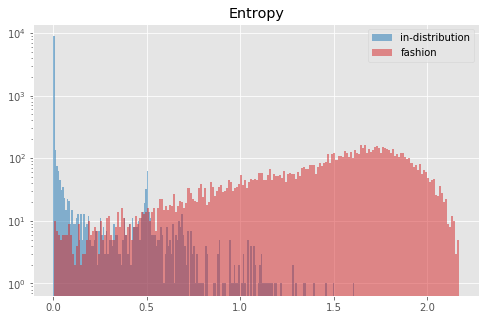

In [13]:
plt.figure(figsize=(8,5))
plt.hist(test_entropy, bins=200, label='in-distribution', color='#1f77b4', alpha=0.5)
plt.hist(ood_entropy, bins=200, label='fashion', color='#d62728', alpha=0.5)
plt.legend()
plt.yscale('log')
plt.title('Entropy')
plt.show()

## Ambiguous samples

In [14]:
def get_extremes_n(data_loader, entropy_values, n=5, image_shape=[28, 28], lowest=False):
    
    if lowest:
        indices = np.argpartition(entropy_values, n)[:n]
    else:
        indices = np.argpartition(entropy_values, -n)[-n:]

    entropy = entropy_values[indices]
    images = np.zeros([n] + image_shape)
    labels = []
    predictions = []
    
    counter = 0
    for index, image in enumerate(data_loader):
        
        if index in indices:
            images[counter] = image[0]
            labels.append(image[1].item())
            output = model(image[0].to(device))
            softmax_output = torch.nn.functional.softmax(output.squeeze(0), 0)
            mean_output = torch.mean(softmax_output, dim=-1)
            prediction = torch.argmax(mean_output)
            predictions.append(prediction.item())
            counter += 1
    
    return images, labels, predictions, entropy

### In distribution samples with high uncertainty

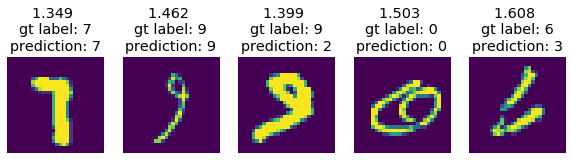

In [15]:
images, labels, predictions, entropy = get_extremes_n(test_loader, test_entropy, lowest=False)

plt.figure(1, figsize=(10, 8))
for i in range(5):
    plt.subplot(1,5,i + 1)
    plt.imshow(images[i])
    plt.title('{:.3f} \n{}: {}\n{}: {}'.format(entropy[i], 'gt label', labels[i], 'prediction', predictions[i]))
    plt.axis('off')
plt.show()

### OOD samples with low uncertainty

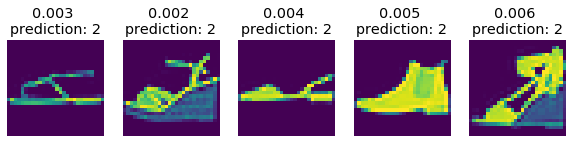

In [16]:
images, labels, predictions, entropy = get_extremes_n(fashion_loader, ood_entropy, lowest=True)

plt.figure(1, figsize=(10, 8))
for i in range(5):
    plt.subplot(1,5,i + 1)
    plt.imshow(images[i])
    plt.title('{:.3f} \n{}: {}'.format(entropy[i], 'prediction', predictions[i]))
    plt.axis('off')
plt.show()

## AUC

### out-of-distribution: Fashion MNIST

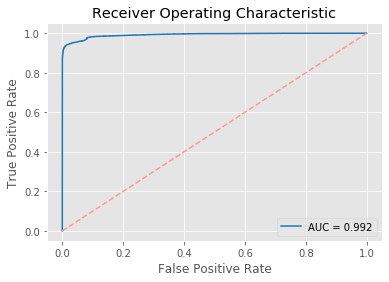

In [17]:
from sklearn import metrics

y_pred = np.concatenate([test_predictions.max(1), ood_predictions.max(1)])
y_true = np.concatenate([np.ones(len(test_predictions)), np.zeros(len(ood_predictions))])
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
roc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, '#1f77b4', label = 'AUC = %0.3f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color='#ff9896')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()